## 0. Setup

### 0.1. Import

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from utils.visualization import visualize
from torchmetrics import Accuracy

### 0.2 Verify GPU access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data

### 1.1. Create a dataset

In [3]:
NUM_SAMPLES = 1000
RANDOM_SEED = 42

In [4]:
X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

In [5]:
data_df = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "y": y})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


### 1.2. Split data into training & test sets

In [6]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 1.3. Visualize data

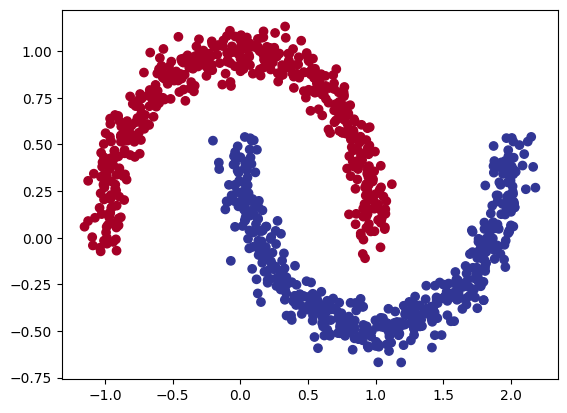

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## 2. Build a model

### 2.1. Model Class Creation
   - `MoonModel`: multi-layer perceptrons (MLPs), capable of learning complex, non-linear relationships like a moon shape.

In [8]:
class MoonModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=in_features, 
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, 
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [9]:
model = MoonModel(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Training

### 3.1. Initialize Loss Function & Optimizer
- **Loss Function**:
  - **`nn.BCEWithLogitsLoss`**:
    - Combines a Sigmoid layer and Binary Cross-Entropy loss for better numerical stability.
    - Suitable for binary classification tasks.
- **Optimizer**:
    - **`torch.optim.SGD`**:
    - Optimization method: Stochastic Gradient Descent

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

### 3.2. Optimization Loop

In [11]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train.int())
    
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval() 
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int()) 

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.66 Acc: 0.80 | Test loss: 0.66 Test acc: 0.78
Epoch: 100 | Loss: 0.29 Acc: 0.86 | Test loss: 0.30 Test acc: 0.86
Epoch: 200 | Loss: 0.23 Acc: 0.89 | Test loss: 0.23 Test acc: 0.89
Epoch: 300 | Loss: 0.22 Acc: 0.90 | Test loss: 0.22 Test acc: 0.90
Epoch: 400 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.91
Epoch: 500 | Loss: 0.17 Acc: 0.93 | Test loss: 0.16 Test acc: 0.93
Epoch: 600 | Loss: 0.11 Acc: 0.95 | Test loss: 0.10 Test acc: 0.97
Epoch: 700 | Loss: 0.07 Acc: 0.99 | Test loss: 0.06 Test acc: 0.99
Epoch: 800 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 900 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00


### 3.3. Evaluation

In [12]:
print(f"Predictions: {test_pred[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {acc_fn(test_pred, y_test.int())*100}%")

Predictions: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
Labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
Test accuracy: 100.0%


### 3.4. Visualization

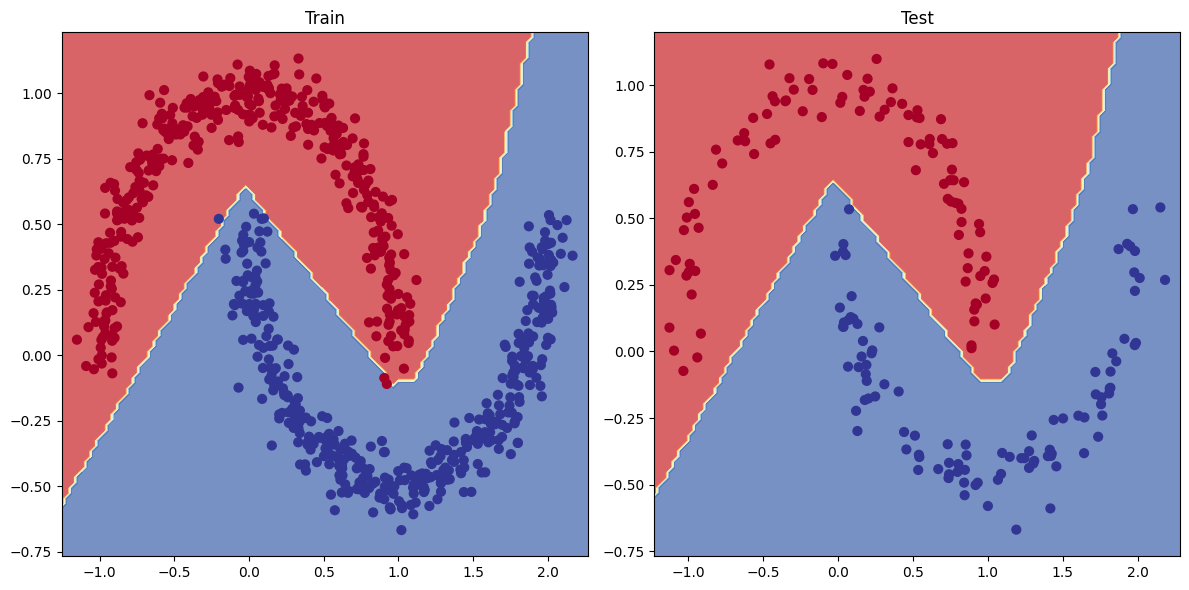

In [13]:
visualize(model, X_train, y_train, X_test, y_test)